<a href="https://colab.research.google.com/github/ammobam/Study_DeepLearing/blob/main/210809_%EC%83%9D%EC%84%B1%EB%AA%A8%EB%8D%B8_AutoEncoder_GAN_StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#** 생성모델

In [ ]:
# 공통 코드
# 파이썬 >= 3.5 필수
import sys
assert sys.version_info >= (3,5)

# 사이킷런 >= 0.20 필수
import sklearn
assert sklearn.__version__ >="0.20"

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import seaborn as sns
import os

# 시드 설정
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 음수 출력
mpl.rcParams['axes.unicode_minus'] = False

# 폰트 설정
import platform
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
	rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

# 경고 없애기
import warnings
warnings.filterwarnings(action='ignore')

# 텐서플로와 케라스
import tensorflow as tf
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 사전 준비


### 데이터 불러오기

In [ ]:
# 데이터 생성
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# numpy 배열로 변경
X_train_full = X_train_full.astype(np.float32)/255
y_train_full = X_train_full.astype(np.float32)/255

X_test = X_test.astype(np.float32)/255

# 훈련데이터, 검증데이터 나누기
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


### 이미지 시각화 함수

* plt.subplt(row, columns, index)
```
┌────┬────┬────┬────┬────┐
│ (2,5,1)│ (2,5,2)│ (2,5,3)│ (2,5,4)│ (2,5,5)│
├────┼────┼────┼────┼────┤
│ (2,5,6)│(2,5,7) │(2,5,8) │(2,5,9) │(2,5,10)│
└────┴────┴────┴────┴────┘
```



In [ ]:
import matplotlib.pyplot as plt

def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    #plt.show()

def show_reconstructions(model, images=X_valid, n_images=5):
    # 예측 - 재구성된 이미지
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 2, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])

        plt.subplot(2, n_images, 6 + image_index)
        plot_image(reconstructions[image_index])

    plt.show()

# ** Auto Encoder

## Convolutinal Auto Encoder
- 합성곱 오토 인코더
- CNN을 적용한 오토인코더

- 이미지를 다루는 경우,
    - 이미지가 매우 작지 않다면 오토 인코더의 성능은 좋지 않음
    - CNN(합성곱 신경망)이 밀집 네트워크(dense층)보다 훨씬 좋은 성능을 냄

- 비지도 사전훈련이나 차원 축소를 위해서 이미지에 대한 Auto Encoder를 만들 때도
- CNN을 이용하는 것이 좋은 성능을 만드는 경우가 많음

(1) 인코더
- 합성곱층 풀링층으로 구성된 CNN
- 입력한 데이터의 공간 방향의 차원을 줄이고 (높이, 너비를 줄임)
- 깊이를 늘림 (특성맵의 개수를 늘림)

(2) 디코더
- 이미지의 스케일을 늘리고 깊이를 원본 차원으로 되돌림
- 전치 합성곱 층을 사용함

In [ ]:
# 인코더 생성
conv_encoder = keras.models.Sequential([
                                        keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
                                        keras.layers.Conv2D(16, kernel_size=3, padding='SAME', activation='selu'),
                                        keras.layers.MaxPool2D(pool_size=2),
                                        # keras.layers.AvgPool2D

                                        # ?? 합성곱 층은 늘릴 때마다 신경망 개수 늘려야 함
                                        keras.layers.Conv2D(32, kernel_size=3, padding='SAME', activation='selu'),
                                        keras.layers.MaxPool2D(pool_size=2),
                                        keras.layers.Conv2D(64, kernel_size=3, padding='SAME', activation='selu'),
                                        keras.layers.MaxPool2D(pool_size=2)
])

In [ ]:
# 디코더 생성
## 인코더의 반대로 잘 풀어내가며 쌓자
## input_shape는 첫번째 층에만 설정. 나머지 층은 이전 층이 준 거 알아서 처리함.
conv_decoder = keras.models.Sequential([
                                        keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2,
                                                                     padding='VALID', activation='selu', input_shape=[3,3,64]),
                                        # strides를 설정하면 노이즈가 적당히 섞임
                                        # input_shape는 인코더의 kernel_size와 잘 맞춰줘야 함
                                        # padding은 데이터의 길이를 맞춰줌
                                        ## 첫 층은 유효한 구조(VALID)를 다 받아와도 괜찮지만
                                        ## 다음 층부터는 층에서 작업한 결과물의 구조가 달라지므로 SAME을 설정하는 것이 편함
                                        ## 아래 층에서 모두 VALID를 설정한 경우, 마지막 층이 받는 데이터 구조는 31, 31, 1임
                                        keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='SAME', activation='selu'),
                                        keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='SAME', activation='sigmoid'),
                                        keras.layers.Reshape([28, 28])
])

In [ ]:
# 합성곱 오토 인코더
# 생성
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

# 컴파일
conv_ae.compile(loss='binary_crossentropy', optimizer = keras.optimizers.SGD(learning_rate=1.0), metrics=['accuracy'])

In [ ]:
# 훈련
conv_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
# 여기선 이미지를 생성하는거니까... 훈련데이터랑 답안데이터가 같음
# val_accuracy: 0.2618

Epoch 1/5
1719/1719 [==============================] - 72s 41ms/step - loss: 0.3009 - accuracy: 0.1596 - val_loss: 0.2815 - val_accuracy: 0.1994
Epoch 2/5
1719/1719 [==============================] - 69s 40ms/step - loss: 0.2753 - accuracy: 0.2127 - val_loss: 0.2768 - val_accuracy: 0.2351
Epoch 3/5
1719/1719 [==============================] - 69s 40ms/step - loss: 0.2707 - accuracy: 0.2413 - val_loss: 0.2697 - val_accuracy: 0.2500
Epoch 4/5
1719/1719 [==============================] - 70s 41ms/step - loss: 0.2682 - accuracy: 0.2602 - val_loss: 0.2694 - val_accuracy: 0.2554
Epoch 5/5
1719/1719 [==============================] - 70s 41ms/step - loss: 0.2665 - accuracy: 0.2722 - val_loss: 0.2695 - val_accuracy: 0.2920


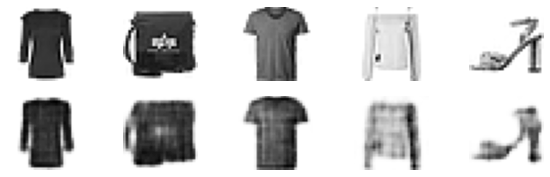

In [ ]:
# 합성곱 오토 인코더로 생성한 이미지 출력
show_reconstructions(conv_ae)

## Recurrent Auto Encoder
- 순환 오토 인코더
- Simple ENN, LSTM, GRU층이 있음

- 비지도 학습이나 차원 축소를 위해 
- 시계열이나 텍스트와 같은 시퀀스에 대한 오토 인코더를 만들 땐
- 순환신경망(RNN)이 밀집 네트워크보다 성능이 좋을 수 있음

(1) 인코더
- 입력 시퀀스를 하나의 벡터로 압축하는 시퀀스 투 벡터 RNN을 이용

(2) 디코더
- 벡터 투 시퀀스 RNN을 이용함


In [ ]:
# 동일한 경과를 만들기 위한 설정
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 인코더 생성
recurrent_encoder = keras.models.Sequential([
                                            keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
                                            keras.layers.LSTM(30)
])

In [ ]:
# 디코더 생성
# 인코더 생성
recurrent_decoder = keras.models.Sequential([
                                            keras.layers.RepeatVector(28, input_shape=[30]), # 왜 30일까? --> 인코더 마지막 층이 뉴런 30개임
                                            keras.layers.LSTM(100, return_sequences=True),
                                            keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid')                                            )
])

In [ ]:
#help(keras.layers.LSTM)

In [ ]:
# 합성곱 오토 인코더
# 생성
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

# 컴파일
recurrent_ae.compile(loss='binary_crossentropy', optimizer = keras.optimizers.SGD(learning_rate=0.1), metrics=['accuracy'])

In [ ]:
# 훈련
recurrent_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
# 여기선 이미지를 생성하는거니까... 훈련데이터랑 답안데이터가 같음
# val_accuracy: 0.0714 - 이미지 쪽에 RNN은 별로 효과가 없음

Epoch 1/5
1719/1719 [==============================] - 117s 65ms/step - loss: 0.5019 - accuracy: 0.0444 - val_loss: 0.4505 - val_accuracy: 0.0477
Epoch 2/5
1719/1719 [==============================] - 111s 64ms/step - loss: 0.4008 - accuracy: 0.0472 - val_loss: 0.3761 - val_accuracy: 0.0538
Epoch 3/5
1719/1719 [==============================] - 110s 64ms/step - loss: 0.3677 - accuracy: 0.0589 - val_loss: 0.3610 - val_accuracy: 0.0664
Epoch 4/5
1719/1719 [==============================] - 111s 64ms/step - loss: 0.3530 - accuracy: 0.0696 - val_loss: 0.3508 - val_accuracy: 0.0703
Epoch 5/5
1719/1719 [==============================] - 109s 64ms/step - loss: 0.3430 - accuracy: 0.0737 - val_loss: 0.3395 - val_accuracy: 0.0714


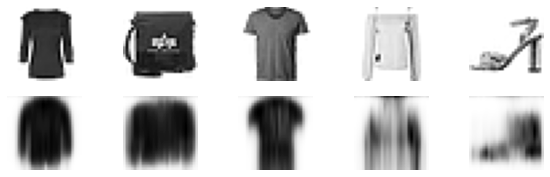

In [ ]:
# 순환 오토 인코더로 생성한 이미지 출력
show_reconstructions(recurrent_ae)

## Denoise Auto Encoder
- 잡음 제거 오토인코더
- 입력에 노이즈를 추가하고, 노이즈가 없는 원본 입력을 복원하여 유용한 특성을 학습하도록 강제함

- 이용하는 노이즈
    - 가우시안 노이즈(정규분포)
    - 드롭아웃


#### 가우시안 노이즈 추가

In [ ]:
# 동일한 경과를 만들기 위한 설정
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 인코더 생성
denoise_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]),
                                           keras.layers.GaussianNoise(0.2),
                                           keras.layers.Dense(100, activation='selu'),
                                           keras.layers.Dense(30, activation='selu')
])
# Dense층의 기능 : 데이터를 잘게 분할해서 봄 ■■■■■ #!!
# 이 경우는 이미지를 100회 분할하고, 각 조각을 다시 30회 분할함
# 그럼 Dense(100) * Dense(30)은 Dense(3000)과 같을까? --> No!
# Dense(100) * Dense(30)는 30회 쪼갤 때 이미지 영역이 겹쳐 쪼갤 수 있지만
# Dense(3000)는 겹치는 영역이 없을 수 있음
# 둘 다 3000개의 조각이 나오는 것은 맞지만, 각 조각이 다른 데이터를 의미할수 있음
# 그리고 Dense 층을 여러 겹 쓰는 것이 더 효율적인 일처리가 될 수 있음
    ## 사진에 바퀴가 있는가? --> Yes/No 분류하여 Yes에 해당하는 데이터만 재가공하는 스무고개 식으로.. 각 층마다 처리할 데이터 수가 줄어들테니 효율적.

In [ ]:
# 디코더 생성
denoise_decoder = keras.models.Sequential([keras.layers.Dense(100, activation='selu', input_shape=[30]),
                                           keras.layers.Dense(28*28, activation='sigmoid'),
                                           keras.layers.Reshape([28, 28])                                                              
])

In [ ]:
# 디노이즈 오토 인코더
# 생성
denoise_ae = keras.models.Sequential([denoise_encoder, denoise_decoder])

# 컴파일
denoise_ae.compile(loss='binary_crossentropy', optimizer = keras.optimizers.SGD(learning_rate=0.1), metrics=['accuracy'])

In [ ]:
# 훈련
denoise_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
# 여기선 이미지를 생성하는거니까... 훈련데이터랑 답안데이터가 같음
# 실제로는 1000번 정도 수행하여 acurracy를 높여서 사용함

Epoch 1/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4769 - accuracy: 0.0484 - val_loss: 0.3835 - val_accuracy: 0.0558
Epoch 2/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3700 - accuracy: 0.0594 - val_loss: 0.3633 - val_accuracy: 0.0611
Epoch 3/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3546 - accuracy: 0.0683 - val_loss: 0.3482 - val_accuracy: 0.0751
Epoch 4/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3410 - accuracy: 0.0781 - val_loss: 0.3362 - val_accuracy: 0.0798
Epoch 5/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3314 - accuracy: 0.0817 - val_loss: 0.3286 - val_accuracy: 0.0832


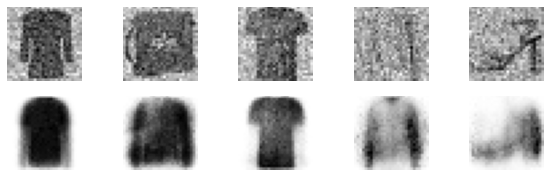

In [ ]:
# 디노이즈 오토 인코더로 생성한 이미지 출력
# 우리가 넣어준 노이즈 낀 이미지와 처리한 이미지 비교
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoise_ae, noise(X_valid, training=True))

#### 드랍아웃 적용

In [ ]:
# 인코더 생성
denoise_encoder2 = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]),
                                           keras.layers.GaussianNoise(0.2),
                                           keras.layers.Dropout(0.5),    ## 드롭아웃 층 추가
                                           keras.layers.Dense(100, activation='selu'),
                                           keras.layers.Dense(30, activation='selu')
])

In [ ]:
# 디코더 생성
denoise_decoder2 = keras.models.Sequential([keras.layers.Dense(100, activation='selu', input_shape=[30]),
                                           keras.layers.Dense(28*28, activation='sigmoid'),
                                           keras.layers.Reshape([28, 28])                                                              
])

In [ ]:
# 생성
denoise_ae2 = keras.models.Sequential([denoise_encoder2, denoise_decoder2])

# 컴파일
denoise_ae2.compile(loss='binary_crossentropy', optimizer = keras.optimizers.SGD(learning_rate=0.1), metrics=['accuracy'])

In [ ]:
# 훈련
history = denoise_ae2.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
# val_accuracy: 0.0810

Epoch 1/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4776 - accuracy: 0.0491 - val_loss: 0.3857 - val_accuracy: 0.0561
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3752 - accuracy: 0.0599 - val_loss: 0.3640 - val_accuracy: 0.0612
Epoch 3/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3603 - accuracy: 0.0648 - val_loss: 0.3504 - val_accuracy: 0.0709
Epoch 4/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3480 - accuracy: 0.0743 - val_loss: 0.3388 - val_accuracy: 0.0786
Epoch 5/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3392 - accuracy: 0.0795 - val_loss: 0.3315 - val_accuracy: 0.0828


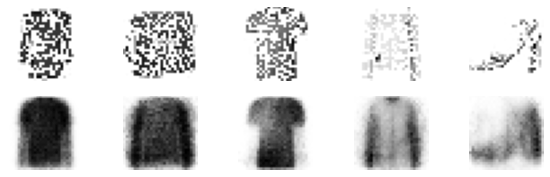

In [ ]:
# 디노이즈 오토 인코더로 생성한 이미지 출력
# 우리가 넣어준 드롭아웃 적용한 이미지와 처리한 이미지 비교
dropout = keras.layers.Dropout(0.5)
show_reconstructions(denoise_ae2, dropout(X_valid, training=True))

## Sparse Auto Encoder
- 희소 오토 인코더
- 비용함수에 적절한 항을 추가해서 코딩 층에서 활성화되는 **뉴런 수를 감소**시켜 만드는 방법
    - 당연히 성능은 떨어짐
- 시그모이드 활성화 함수를 사용하고, 코딩 층의 활성화 값에 L1 규제를 추가함
    - L1 : Lasso - 미분 반복하여 0이 되는 때도 있음
    - L2 : Ridge - 영향력을 줄이기만 함
    - ElasticNet : L1, L2의 혼합

(1) 인코더
- ActivityRegularzation 층을 추가하여 L1 값을 설정
- 일반적으로 작은 값을 사용함. 0.001 정도

In [ ]:
# 인코더 생성
sparse_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]),
                                          keras.layers.Dense(100, activation='selu'),
                                          keras.layers.Dense(30, activation='sigmoid'),  # 마지막 층이 sigmoid면 됨
                                          keras.layers.ActivityRegularization(l1=1e-3)  # 0.001 # 인코더 마지막 층에 L1 규제를 적용함
])

In [ ]:
# 디코더 생성
sparse_decoder = keras.models.Sequential([keras.layers.Dense(100, activation='selu', input_shape=[30]),
                                          keras.layers.Dense(28*28, activation='sigmoid'),
                                          keras.layers.Reshape([28, 28])                                                              
])

In [ ]:
# 생성
sparse_ae = keras.models.Sequential([sparse_encoder, sparse_decoder])

# 컴파일
sparse_ae.compile(loss='binary_crossentropy', optimizer = keras.optimizers.SGD(learning_rate=0.1), metrics=['accuracy'])

In [ ]:
# 훈련
history = sparse_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
# val_accuracy: 0.0556

Epoch 1/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5529 - accuracy: 0.0449 - val_loss: 0.5077 - val_accuracy: 0.0434
Epoch 2/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4977 - accuracy: 0.0446 - val_loss: 0.4915 - val_accuracy: 0.0437
Epoch 3/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4764 - accuracy: 0.0449 - val_loss: 0.4643 - val_accuracy: 0.0449
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4417 - accuracy: 0.0480 - val_loss: 0.4247 - val_accuracy: 0.0498
Epoch 5/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4103 - accuracy: 0.0532 - val_loss: 0.4041 - val_accuracy: 0.0529


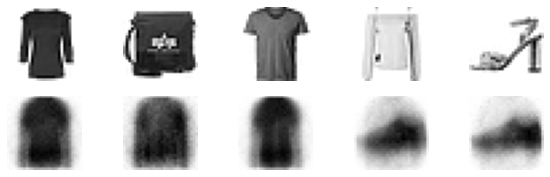

In [ ]:
# Sparse 오토 인코더로 생성한 이미지 출력
# L1 규제를 적용한 이미지와 처리한 이미지 비교
l1regular = keras.layers.ActivityRegularization(l1=0.001)
show_reconstructions(sparse_ae, l1regular(X_valid, training=True))

* selu, sigmoid의 차이
* selu

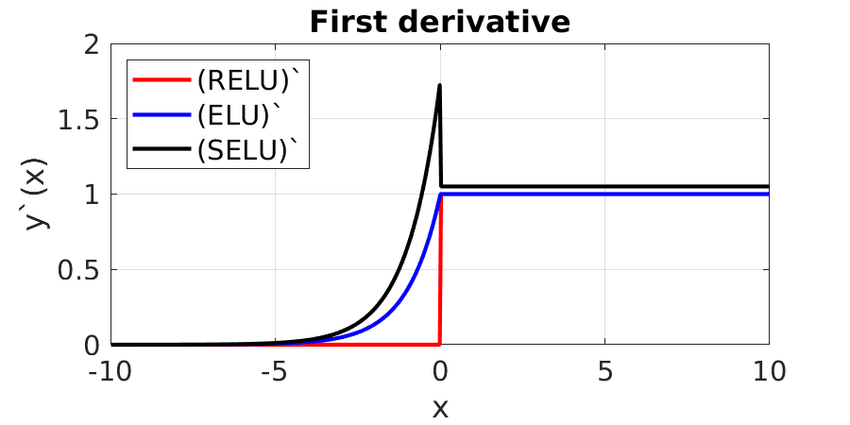
* sigmoid
    * http://taewan.kim/post/sigmoid_diff/
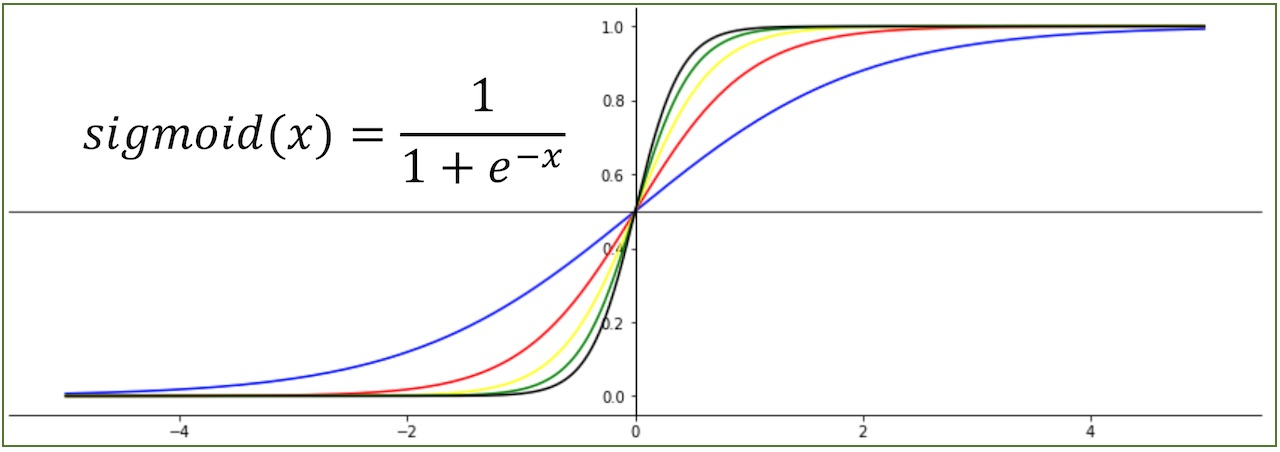

## VAE
- Variational Auto Encoder
- 특징
    - 변이 오토 인코더
        - 생성 모델링에서 가장 기본적이고 널리 알려진 딥러닝 구조 중 하나
    - 확률에 기반함. 훈련이 끝난 후에도 출력이 부분적으로 우연에 의해 결정됨.
        - 다른 오토 인코더 : 훈련할 때만 우연이 적용됨
    - 생성 오토 인코더
    	- 훈련 세트에서 샘플링 된 것 같은 새로운 샘플을 만들 수 있음

- 구동 원리
    - 인코더 : 평균, 표준편차를 생성
    - 실제 코딩을 만들 때 : 생성한 평균, 표준편차로 가우시안 분포를 만들고 샘플링
    - 디코더 : 출력
        - 가우시안 잡음이 추가됨

- VAE 생성 방법
    - keras.layers.layer로부터 클래스를 상속받아 __call__ 메소드를 재정의함
    - inputs의 평균, 표준편차를 받아서 정규분포를 만들고
    - 하나의 데이터를 리턴하도록 함

- 참고
- https://taeu.github.io/paper/deeplearning-paper-vae/

### 샘플링을 위한 클래스 만들기
- 패션 MNIST에 VAE 적용

In [ ]:
# 케라스의 레이어 클래스를 상속 받아서 VAE 구현하기

K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        # 평균과 표준편차 가져오기
        mean, log_var = inputs
        # K.random_normal : 정규분포 생성
        # 지수함수(K.exp)를 곱하고 평균을 더함
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean

### 모델 생성 및 훈련

In [ ]:
# 동일한 경과를 만들기 위한 설정
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 함수형 API를 이용하여 Variational AE 생성

# 패션 MNSIST는 데이터의 종류가 10가지
coding_size = 10

In [ ]:
# 인코더

# 입력층 생성
inputs = keras.layers.Input(shape=[28, 28])

# 1차원으로 펼치기
z = keras.layers.Flatten()(inputs)

# 밀집 네트워크 처리
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)

# 출력층 생성
# mean과 log_var를 생성함
codings_mean = keras.layers.Dense(coding_size)(z)
codings_log_var = keras.layers.Dense(coding_size)(codings_mean)    #!!
# 샘플링 층 생성
codings = Sampling()([codings_mean, codings_log_var])

# 인코더 생성
variational_encoder = keras.models.Model(
    inputs = [inputs], outputs = [codings_mean, codings_log_var, codings]
)

In [ ]:
# 디코더
decoder_inputs = keras.layers.Input(shape=[coding_size])

# 밀집 네트워크 처리
## 인코더 층과 대칭되게 만들어야 함
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(28*28, activation='sigmoid')(x)

# 디코더 생성
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(
    inputs = [decoder_inputs], outputs = [outputs]
)

In [ ]:
# 인코더와 디코더를 이용한 모델 생성
## 인코더로부터 코드 받아서
_, _, codings = variational_encoder(inputs)
## 디코더 처리한 값을 받아오고
reconstructions = variational_decoder(codings)

# 모델 생성
variational_AE = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

In [ ]:
# 모델에 잠재 손실과 재구성 손실을 추가함
# 손실 계산
latent_loss = -0.5 * K.sum(1 + codings_log_var + K.exp(codings_log_var) - K.square(codings_mean), axis = -1) 
# 모델에 추가
variational_AE.add_loss(K.mean(latent_loss)/(28*28))

# 확인
variational_AE.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 10), (None,  133970      input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 28, 28)       134634      model[0][2]                      
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 784)          0           input_1[0][0]                    
____________________________________________________________________________________________

In [ ]:
# 컴파일
variational_AE.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [ ]:
# 훈련
history = variational_AE.fit(X_train, X_train, epochs=25, validation_data=(X_valid, X_valid), batch_size=128)
# batch_size : 데이터 몇개씩 묶음 만들어서 처리할 것인지 설정
# val_accuracy: 0.1307
## loss가 nan...?

Epoch 1/25
430/430 [==============================] - 10s 20ms/step - loss: nan - accuracy: 0.1346 - val_loss: nan - val_accuracy: 0.1307
Epoch 2/25
430/430 [==============================] - 8s 18ms/step - loss: nan - accuracy: 0.1355 - val_loss: nan - val_accuracy: 0.1307
Epoch 3/25
430/430 [==============================] - 8s 19ms/step - loss: nan - accuracy: 0.1355 - val_loss: nan - val_accuracy: 0.1307
Epoch 4/25
430/430 [==============================] - 8s 19ms/step - loss: nan - accuracy: 0.1355 - val_loss: nan - val_accuracy: 0.1307
Epoch 5/25
430/430 [==============================] - 8s 18ms/step - loss: nan - accuracy: 0.1355 - val_loss: nan - val_accuracy: 0.1307
Epoch 6/25
430/430 [==============================] - 8s 18ms/step - loss: nan - accuracy: 0.1355 - val_loss: nan - val_accuracy: 0.1307
Epoch 7/25
430/430 [==============================] - 8s 19ms/step - loss: nan - accuracy: 0.1355 - val_loss: nan - val_accuracy: 0.1307
Epoch 8/25
430/430 [====================

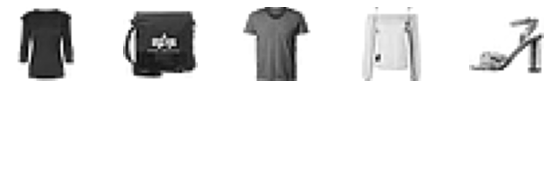

In [ ]:
# VAE로 생성한 이미지 출력
show_reconstructions(variational_AE)

### 새로운 이미지 생성

In [ ]:
# 샘플 출력을 위한 함수
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

        plt.figure(figsize=(n_cols, n_rows))
        for index, image in enumerate(images):
            plt.subplot(n_rows, n_cols, index+1)
            plt.imshow(image, cmap='binary')
            plt.axis('off')

In [ ]:
# 샘플 이미지 생성
tf.random.set_seed(42)
codings = tf.random.normal(shape=[12, coding_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)    ##?? 왜 안그려지지
plt.show()

ValueError: ignored

# ** GAN
- Generative Adversarial Network
- 생성적 적대 신경망
- 2개의 모델이 서로 다른 목적을 가지고 경쟁하면서 발전하는 방법
    - Generator(생성자)가 학습에 필요한 데이터를 만듦
    - 만들어지는 데이터가 Discriminator(판별자)를 속이기 위한 가짜임(적대적임!)

- Discriminator(판별자)의 목적
    - 원본과 Generator가 생성해낸 가짜 데이터와 잘 구분하는 것
    - 이진 분류 문제를 풀게됨

- Generator(생성자)의 목적
    - 자신이 만들어낸 가짜 데이터를 Discriminator가 진짜라고 판단하도록 함

---
## 훈련 방법
- 기존의 신경망과는 훈련 방법이 다름
- 1단계-2단계를 반복하며 생성자를 최적화함

1) 1단계

    - 레이블링 : 1은 진짜 이미지, 0은 가짜 이미지

    - 생성자
        - 생성자는 실제 이미지 배치를 샘플링 함
        - 동일한 숫자의 가짜 이미지를 만들어서 합성곱 함

    - 판별자
        - 이진 크로스 엔트로피를 사용
        - 한 스텝동안 배치된 데이터를 훈련하고 판별자의 가중치를 최적화함

2) 2단계

    - 가짜 이미지를 만들고 레이블링 함
    - 레이블링 : 전부 1, 판별자가 진짜 이미지로 판별한 이미지만 사용함

    - 판별자의 가중치는 동결
    - 생성자의 가중치를 최적화


## GAN

### 데이터 가져오기

- 생성자 : 오토 인코더의 디코더와 비슷함
- 판별자 : 일반적인 이진 분류기
	- 이미지를 입력으로 받고
	- 하나의 유닛과 시그모이드 활성화 함수로 사용한 Dense 층을 구성함

In [ ]:
# 데이터 가져오기
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# numpy 배열로 변경 및 정규화
X_train_full = X_train_full.astype(np.float32)/255
X_test = X_test.astype(np.float32)/255

# 훈련데이터, 검증데이터 나누기
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
print(X_train.shape)
print(y_train.shape)

(55000, 28, 28)
(55000,)


In [ ]:
# 샘플 출력을 위한 함수
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

        plt.figure(figsize=(n_cols, n_rows))
        for index, image in enumerate(images):
            plt.subplot(n_rows, n_cols, index+1)
            plt.imshow(image, cmap='binary')
            plt.axis('off')

### Generator & Discriminator 만들기

In [ ]:
# 동일한 경과를 만들기 위한 설정
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Generator(생성자) 만들기
# 디코더와 유사함
coding_size = 30

generator = keras.models.Sequential([
                                     keras.layers.Dense(100, activation='selu', input_shape=[coding_size]),
                                     keras.layers.Dense(150, activation='selu'),
                                     keras.layers.Dense(28*28, activation='sigmoid'),
                                     keras.layers.Reshape([28,28])                                     
])
# 확인
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               118384    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 136,634
Trainable params: 136,634
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Discriminator(판별자) 만들기
# 이진 분류기
discriminator = keras.models.Sequential([
                                         keras.layers.Flatten(input_shape=[28,28]),
                                         keras.layers.Dense(150, activation='selu'),
                                         keras.layers.Dense(100, activation='selu'),
                                         keras.layers.Dense(1, activation='sigmoid'),
])
# 확인
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 150)               117750    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 132,951
Trainable params: 132,951
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 생성
gan = keras.models.Sequential([generator, discriminator])

# 확인
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28)            136634    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 132951    
Total params: 269,585
Trainable params: 269,585
Non-trainable params: 0
_________________________________________________________________


* compile의 의미 : 모델을 컴퓨터가 이해할 수 있도록 변환함

In [ ]:
# GAN 컴파일
# 판별자와 모델을 컴파일함

# Discriminator 컴파일
# 진짜, 가짜의 분류이므로 이진 크로스 엔트로피를 사용함
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
# 가중치를 업데이트 하면 안 됨
discriminator.trainable = False

# 모델 컴파일
gan.compile(loss='binary_crossentropy', optimizer ='rmsprop')

### GAN 모델 훈련
- fit을 사용할 수 없음 !
    - ?? fit은 훈련방식이 어떻길래...

In [ ]:
# 데이터를 순회하는 Dataset을 생성함
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
len(dataset)
    # drop_remainder : 배치사이즈로 자르고 남는 데이터를 drop 할 것인지 여부

1718

In [ ]:
# 반복문을 이용해서 직접 훈련함
def train_gan(gan, dataset, batch_size, coding_size, n_epochs=50):
    # 생성자와 판별자 분리
    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print("epoch {} / {}".format(epoch+1, n_epochs))
        
        # 각 배치데이터마다 1단계와 2단계를 반복 수행함
        for X_batch in dataset:

            # 1단계 : 생성자가 노이즈 섞인 데이터 만들고, 판별자가 훈련 ■■■■■■■■
            ## 잡음이 섞인 데이터와 원본 데이터를 합쳐서 훈련함

            # 랜덤하게 노이즈 추가
            noise = tf.random.normal(shape=[batch_size, coding_size])
            generated_images = generator(noise)
            
            # 진짜와 가짜 섞음
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            
            # 진짜와 가짜 레이블 생성
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)    # 왜 괄호를 2개씩 하지?? 
            
            # 판별자에게 훈련 - 가중치 업데이트
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
                ## y1 안 넣으면 : ValueError: No gradients provided for any variable

            # 2단계 : 생성자가 잡음이 섞인 데이터만 생성해서 훈련 ■■■■■■■■
            noise = tf.random.normal(shape=[batch_size, coding_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

        # 시각화
        plot_multiple_images(generated_images, 8)
        plt.show()

### batch_size만큼의 가짜 이미지 생성

In [ ]:
train_gan(gan, dataset, batch_size, coding_size, n_epochs=1)    ##??? 왜 이미지 안 떠.........

epoch 1 / 1


## 심층 합성곱 GAN

In [ ]:
# 동일한 경과를 만들기 위한 설정
tf.random.set_seed(42)
np.random.seed(42)

coding_size = 30

# Generator(생성자) 만들기
# 디코더와 유사함
generator = keras.models.Sequential([
                                     keras.layers.Dense(7*7*128, activation='selu', input_shape=[coding_size]),
                                     keras.layers.Reshape([7,7,128]),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='SAME', activation='selu'),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='SAME', activation='tanh')
])

# Discriminator(판별자) 만들기
# 이진 분류기
discriminator = keras.models.Sequential([
                                         keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='SAME', 
                                                                      activation=keras.layers.LeakyReLU(0.2), input_shape=[28,28,1]),
                                         keras.layers.Dropout(0.4),
                                         keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='SAME', 
                                                                      activation=keras.layers.LeakyReLU(0.2)),
                                         keras.layers.Dropout(0.4),
                                         keras.layers.Flatten(),
                                         keras.layers.Dense(1, activation='sigmoid')
                                         ])

# 모델 생성
deep_gan = keras.models.Sequential([generator, discriminator])

# 확인
deep_gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         401665    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1812225   
Total params: 2,213,890
Trainable params: 2,213,506
Non-trainable params: 384
_________________________________________________________________


In [ ]:
# 판별자와 모델을 컴파일함

# Discriminator 컴파일
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
# 가중치를 업데이트 하면 안 됨
discriminator.trainable = False

# 모델 컴파일
deep_gan.compile(loss='binary_crossentropy', optimizer ='rmsprop')

In [ ]:
# 원본 데이터의 크기를 변경하고 스케일 조정함
X_train_dcgan = X_train.reshape(-1, 28, 28, 1)*2. -1.
    # 4차원으로 바꾸고 스케일 조정

print(X_train_dcgan.shape)

# 데이터를 순회하는 Dataset을 생성함 !!
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
len(dataset)
    # drop_remainder : 배치사이즈로 자르고 남는 데이터를 drop 할 것인지 여부

(55000, 28, 28, 1)


1718

In [ ]:
train_gan(gan=deep_gan, dataset=dataset, batch_size=batch_size, coding_size=coding_size, n_epochs=1)    ##??? 너무 오래 걸림. epochs 1인데...

---
# ** Style Transfer
- 스타일 전이
- 두 장의 서로 다른 이미지를 사용하여 새로운 이미지를 합성하는 방법
    - 사진을 고흐 화풍으로 만들기

- CNN을 통해 각 레이어에서 추출되는 다양한 특징을 이용
- 2개의 이미지 필요함
	- Contents 이미지 : 이미지의 구조, 형태를 추출
	- Style 이미지 : 이미지 고유의 스타일을 추출

## 데이터 전처리

## 모델 만들기

In [ ]:
# 라이브러리 가져오기
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 주피터에서 작업진행상황을 보여주기 위한 패키지
from tqdm import tqdm

# 이미지 처리를 위한 패키지
import cv2
from PIL import Image

(224, 224, 3)


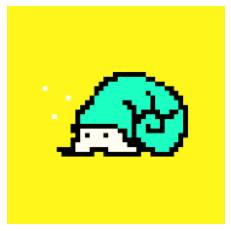

In [ ]:
# contents 이미지
contents = cv2.imread('/content/drive/MyDrive/data/assets/contents.png')
# 사이즈 맞추기
contents = cv2.resize(contents, (224,224))
print(contents.shape)

plt.imshow(cv2.cvtColor(contents, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

(954, 658, 3)
(224, 224, 3)


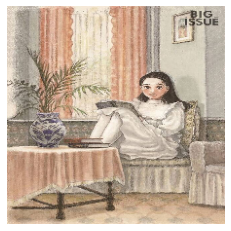

In [ ]:
# contents 이미지
style = cv2.imread('/content/drive/MyDrive/data/assets/style.jpg')
print(style.shape)

#newx,newy = style.shape[1]//4, style.shape[0]//4    #new size (w,h)    # (164, 238)
#style = cv2.resize(style, (newx,newy))
style = cv2.resize(style, (224,224))
print(style.shape)

plt.imshow(cv2.cvtColor(style, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 사전학습 모델 VGG 16 가져오기
* 전이학습 시 유의사항
    - 데이터를 입력층 포맷에 맞춰 전처리하기
    - 전이학습할 모델의 출력층은 가져오지 않고 내 니즈에 맞게 추가하기
    - 가중치를 그대로 쓸 것이라면 수정 안되도록 고정하기

58892288/58889256 [==============================] - 0s 0us/step


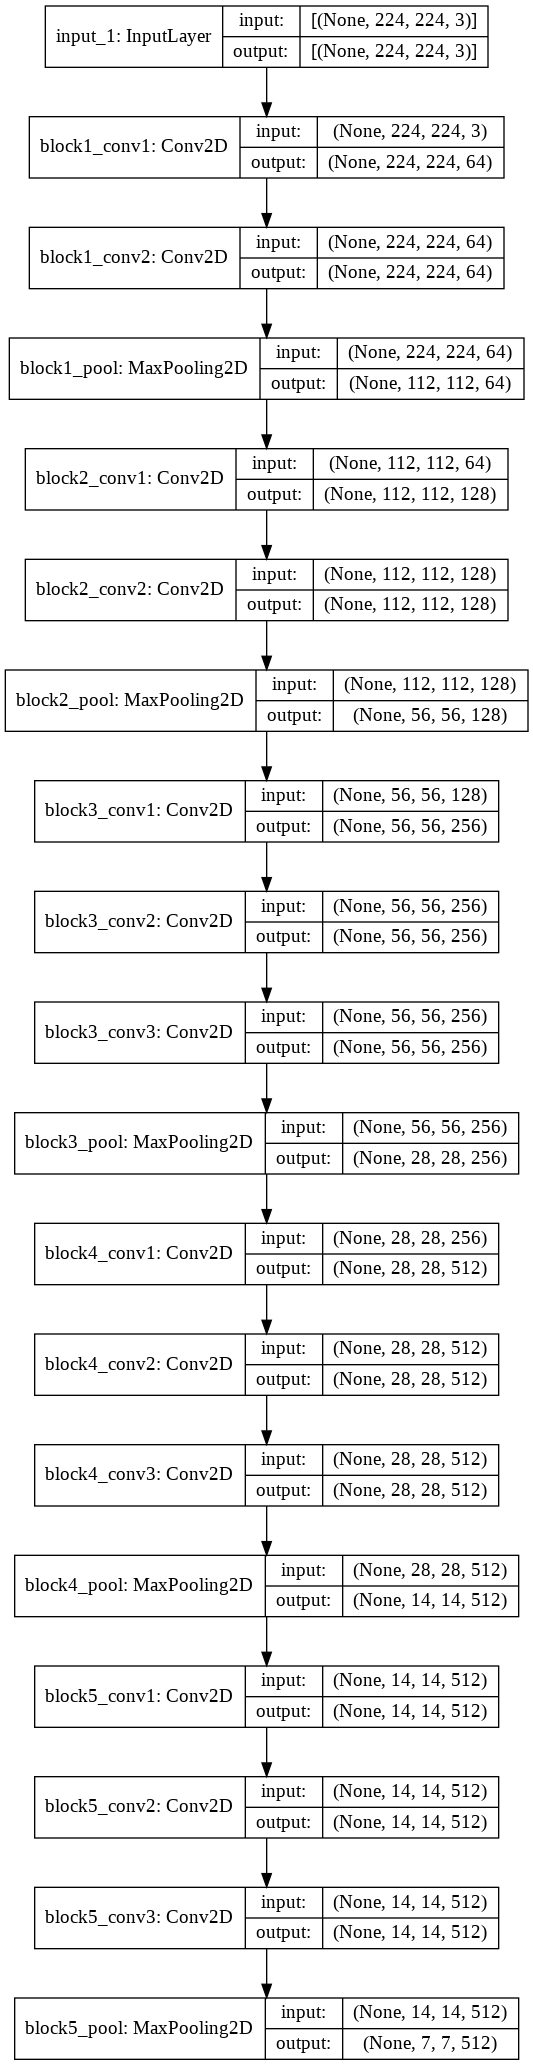

In [ ]:
# 전이학습할 모델 가져오기
vgg_model = tf.keras.applications.VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')
    # include_top=False : 출력층은 빼고 가져옴. 만들어야 함.
    # weights='imagenet' : 이미지넷의 가중치를 그대로 사용함

# 가중치 수정 불가능하도록 고정
vgg_model.trainable = False

# 모델 확인
tf.keras.utils.plot_model(vgg_model, show_shapes=True)

### 스타일 변환 모델 생성
- 사전 훈련된 모델을 바탕으로 함
- block1 ~ 5 층이 있음

In [ ]:
# 스타일 변환 모델 생성
## block5는 안 가져옴
## 출력층 4개
style_transfer_model = tf.keras.Model(inputs=[vgg_model.input],
                                      outputs = [vgg_model.get_layer(name='block1_conv2').output,
                                                 vgg_model.get_layer(name='block2_conv2').output,
                                                 vgg_model.get_layer(name='block3_conv3').output,
                                                 vgg_model.get_layer(name='block4_conv3').output
                                                 ])
style_transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### style 이미지에서 추출한 중요 정보 확인

(1, 224, 224, 64)
(1, 56, 56, 256)


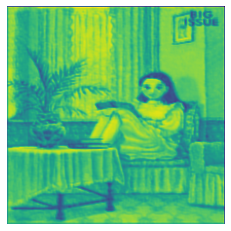

In [ ]:
# style 이미지에서 추출한 중요 정보 확인
style_true_b1c2, style_true_b2c2, style_true_b3c3, style_true_b4c3 = style_transfer_model.predict(np.reshape(style, (-1, 224, 224, 3)))

print(style_true_b1c2.shape)
print(style_true_b3c3.shape)

plt.imshow(style_true_b1c2[0][:,:,25])
## 마지막 64번 배열값을 바꾸면 색상, 입체 등이 다르게 출력됨. vgg모델의 레이어층이 이미지 변환했던 방법을 그대로 가져와 쓰는건가?
plt.axis('off')
plt.show()

(1, 224, 224, 64)
(1, 56, 56, 256)


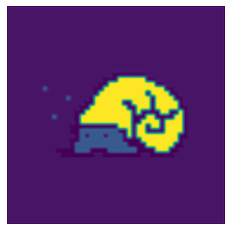

In [ ]:
# contents 이미지에서 추출한 중요 정보 확인
contents_true_b1c2, contents_true_b2c2, contents_true_b3c3, contents_true_b4c3 = style_transfer_model.predict(np.reshape(contents, (-1, 224, 224, 3)))

print(contents_true_b1c2.shape)
print(contents_true_b3c3.shape)

plt.imshow(contents_true_b1c2[0][:,:,27])
plt.axis('off')
plt.show()

## Gram Matrix 함수 정의    # ??
- Gram Matrix
    - 각각의 Feature Map의 Channel을 각각 Flatten하여 새로 만들어질 이미지와 correlation을 갖도록 함

In [ ]:
# Gram Matrix 함수 정의
def gram_matrix(x):
    # transpose는 행렬의 전치
    reshape_x = tf.transpose(x, [2, 1, 0])
    s = tf.shape(reshape_x)    ## shape!!!!! reshape ㄴㄴㄴ
    reshape_x = tf.reshape(reshape_x, (s[0], s[1]*s[2]))
    reshape_x_t = tf.transpose(reshape_x)
    
    # 내적
    dot = tf.matmul(reshape_x, reshape_x_t)
    # 형 변환
    dot = tf.cast(dot, dtype='float32')
    dot = dot / tf.cast(tf.shape(reshape_x)[0], tf.float32) / tf.cast(tf.shape(reshape_x)[1], tf.float32)

    return dot

## 그 외 설정

In [ ]:
# contents 이미지를 입력값으로 생성
input_image = contents
print(contents.shape)

(224, 224, 3)


In [ ]:
# 동영상과 옵티마이저 설정
img_avi = np.zeros((224,224,3)) # 파라미터 한 개에 들어가야 하는 값이라 tuple로 넣음
print(img_avi.shape)

opt = tf.keras.optimizers.Adam(10.0)

fcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('style_transfer.avi', fcc, 10.0, (224, 224))

(224, 224, 3)


## 모델 훈련


1
s_loss : tf.Tensor(186992.84, shape=(), dtype=float32)
c_loss : tf.Tensor(197539.27, shape=(), dtype=float32)

2
s_loss : tf.Tensor(154040.45, shape=(), dtype=float32)
c_loss : tf.Tensor(198090.78, shape=(), dtype=float32)

3
s_loss : tf.Tensor(170714.12, shape=(), dtype=float32)
c_loss : tf.Tensor(206845.7, shape=(), dtype=float32)

4
s_loss : tf.Tensor(139934.28, shape=(), dtype=float32)
c_loss : tf.Tensor(206710.78, shape=(), dtype=float32)

5
s_loss : tf.Tensor(161001.33, shape=(), dtype=float32)
c_loss : tf.Tensor(213694.17, shape=(), dtype=float32)

6
s_loss : tf.Tensor(128754.54, shape=(), dtype=float32)
c_loss : tf.Tensor(212501.1, shape=(), dtype=float32)

7
s_loss : tf.Tensor(151424.6, shape=(), dtype=float32)
c_loss : tf.Tensor(219408.47, shape=(), dtype=float32)

8
s_loss : tf.Tensor(120037.45, shape=(), dtype=float32)
c_loss : tf.Tensor(217364.02, shape=(), dtype=float32)

9
s_loss : tf.Tensor(142780.7, shape=(), dtype=float32)
c_loss : tf.Tensor(223367.1, shape=(), dty

<function destroyAllWindows>

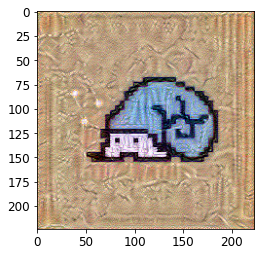

In [ ]:
epochs = 20
for epoch in range(epochs):
    # 입력 이미지는 텐서로 변경해야 함
    input_image = tf.reshape(input_image, (-1, 224, 224, 3))
    input_image = tf.cast(input_image, dtype='float32')
    input_image = tf.Variable(input_image, dtype=tf.float32)

    with tf.GradientTape() as tape:
        b1c2, b2c2, b3c3, b4c3 = style_transfer_model(input_image)
    
        # 손실 구하기
        s_loss_1 = tf.stop_gradient(gram_matrix(style_true_b1c2[0])) - gram_matrix(b1c2[0])
        s_loss_1 = tf.reduce_mean(tf.square(s_loss_1))  #음수가 나오지 않도록 제곱함
        
        s_loss_2 = tf.stop_gradient(gram_matrix(style_true_b2c2[0])) - gram_matrix(b2c2[0])
        s_loss_2 = tf.reduce_mean(tf.square(s_loss_2))

        s_loss_3 = tf.stop_gradient(gram_matrix(style_true_b3c3[0])) - gram_matrix(b3c3[0])
        s_loss_3 = tf.reduce_mean(tf.square(s_loss_3))

        s_loss_4 = tf.stop_gradient(gram_matrix(style_true_b4c3[0])) - gram_matrix(b4c3[0])
        s_loss_4 = tf.reduce_mean(tf.square(s_loss_4))
        
        c_loss_1 = contents_true_b1c2 - b1c2
        c_loss_1 = tf.reduce_mean(tf.square(c_loss_1))
        
        c_loss_2 = contents_true_b2c2 - b2c2
        c_loss_2 = tf.reduce_mean(tf.square(c_loss_2))
        
        c_loss_3 = contents_true_b3c3 - b3c3
        c_loss_3 = tf.reduce_mean(tf.square(c_loss_3))
        
        c_loss_4 = contents_true_b4c3 - b4c3
        c_loss_4 = tf.reduce_mean(tf.square(c_loss_4))

        # 전체 손실 계산
        # style loss는 sum, contents loss는 mean
        s_loss = (s_loss_1 + s_loss_2 + s_loss_3 + s_loss_4)
        c_loss = (c_loss_1 + c_loss_2 + c_loss_3 + c_loss_4) / 4.
        # 적절한 손실값 구하기
        loss = s_loss * 10 + c_loss

    # 녹화
    ## loss를 적용해가면서 녹화함
    grad = tape.gradient(loss, input_image)
    opt.apply_gradients([(grad, input_image)])    # 여길 
    
    input_image=tf.cast(input_image,dtype=tf.int32) ##
    
    input_image = tf.clip_by_value(input_image, 0, 255)
    img_avi = input_image.numpy()[0]
    
    ## 녹화 조건. 10회마다 녹화함
    if ((epoch + 0) % 10 == 0):
        cv2.imwrite('{}.jpg'.format(epoch), img_avi)
    out.write(np.uint8(img_avi))

    print()
    print(epoch+1)
    print("s_loss :", s_loss)
    print("c_loss :", c_loss)

plt.imshow(input_image[0][:, :, ::-1])
# 메모리 해제 - 외부 자원 사용한 다음 꼭 릴리즈 해주자! 음원, 영상 등 재생한 이후!
out.release()
cv2.destroyAllWindows()